In [19]:
%matplotlib inline
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

pm.set_tt_rng(42)
np.random.seed(42)

In [20]:
def w1(z):
    return tt.sin(2.0 * np.pi * z[0] / 4.0)


def w2(z):
    return 3.0 * tt.exp(-0.5 * ((z[0] - 1.0) / 0.6) ** 2)


def w3(z):
    return 3.0 * (1 + tt.exp(-(z[0] - 1.0) / 0.3)) ** -1


def pot1(z):
    z = z.T
    return 0.5 * ((z.norm(2, axis=0) - 2.0) / 0.4) ** 2 - tt.log(
        tt.exp(-0.5 * ((z[0] - 2.0) / 0.6) ** 2) + tt.exp(-0.5 * ((z[0] + 2.0) / 0.6) ** 2)
    )


def pot2(z):
    z = z.T
    return 0.5 * ((z[1] - w1(z)) / 0.4) ** 2 + 0.1 * tt.abs_(z[0])


def pot3(z):
    z = z.T
    return -tt.log(
        tt.exp(-0.5 * ((z[1] - w1(z)) / 0.35) ** 2)
        + tt.exp(-0.5 * ((z[1] - w1(z) + w2(z)) / 0.35) ** 2)
    ) + 0.1 * tt.abs_(z[0])


def pot4(z):
    z = z.T
    return -tt.log(
        tt.exp(-0.5 * ((z[1] - w1(z)) / 0.4) ** 2)
        + tt.exp(-0.5 * ((z[1] - w1(z) + w3(z)) / 0.35) ** 2)
    ) + 0.1 * tt.abs_(z[0])


z = tt.matrix("z")
z.tag.test_value = pm.floatX([[0.0, 0.0]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))

In [21]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j, -ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap("inferno")
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax

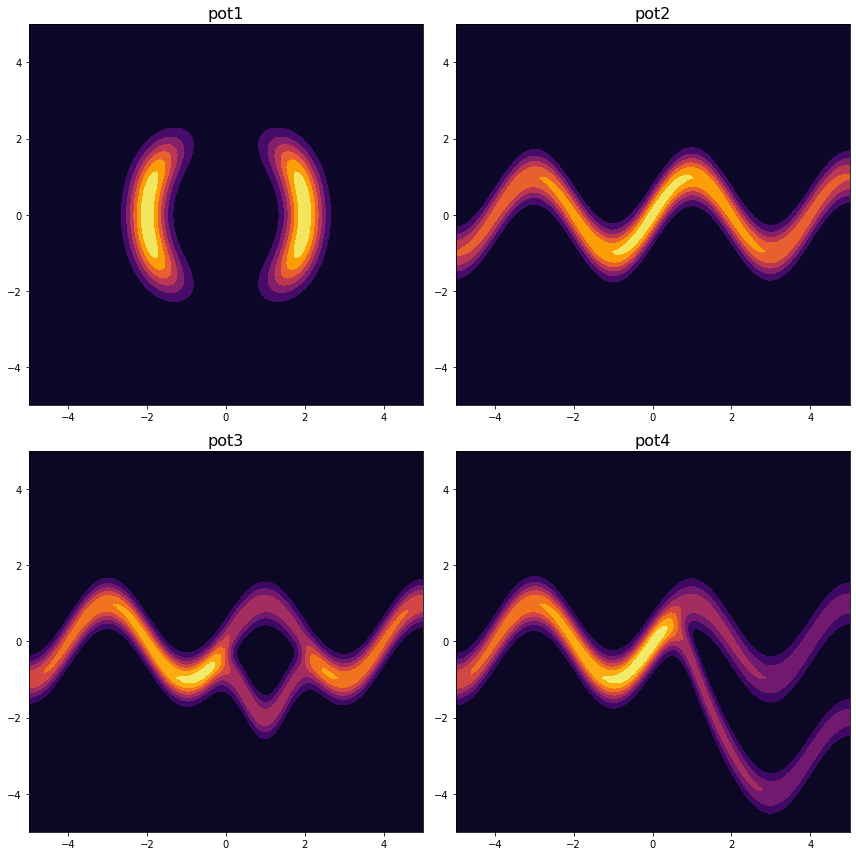

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
contour_pot(pot1f, ax[0], "pot1")
contour_pot(pot2f, ax[1], "pot2")
contour_pot(pot3f, ax[2], "pot3")
contour_pot(pot4f, ax[3], "pot4")
fig.tight_layout()

In [23]:
from pymc3.distributions.dist_math import bound


def cust_logp(z):
    # return bound(-pot1(z), z>-5, z<5)
    return -pot1(z)


with pm.Model() as pot1m:
    pm.DensityDist("pot1", logp=cust_logp, shape=(2,))

In [24]:
pot1m.logp

In [25]:
pm.set_tt_rng(42)
np.random.seed(42)
with pot1m:
    trace = pm.sample(
        1000,
        init="auto",
        cores=2,
        start=[dict(pot1=np.array([-2, 0])), dict(pot1=np.array([2, 0]))],
    )

/tmp/ipykernel_1195045/1415677367.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8955206009002503, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


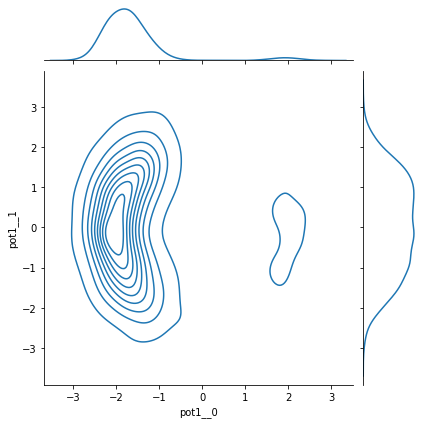

In [26]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind="kde")

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


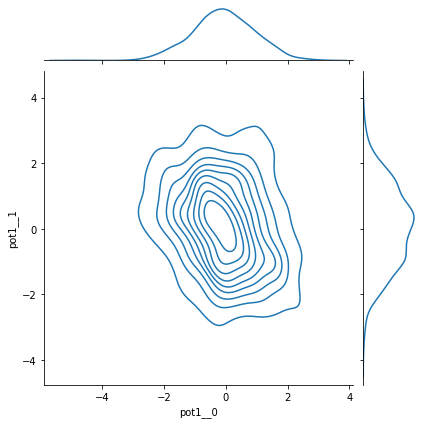

In [27]:
with pot1m:
    inference = pm.NFVI("planar*2", jitter=1)

## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind="kde");

In [28]:
inference.approx.params

[b, u, w, b, u, w]

In [29]:
with theano.configparser.change_flags(compute_test_value="off"):
    grads = tt.grad(inference.objective(None), inference.approx.params)
grads

[Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0]

In [30]:
from collections import OrderedDict, defaultdict
from itertools import count


@theano.configparser.change_flags(compute_test_value="off")
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ["%s_%d" % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(
        **OrderedDict(
            [(name, v.eval) for name, v in zip(names, params)]
            + [("grad_" + name, v.eval) for name, v in zip(names, grads)]
        )
    )


tracker = get_tracker(inference)

In [31]:
tracker.whatchdict

{'b_0': <bound method Variable.eval of b>,
 'u_0': <bound method Variable.eval of u>,
 'w_0': <bound method Variable.eval of w>,
 'b_1': <bound method Variable.eval of b>,
 'u_1': <bound method Variable.eval of u>,
 'w_1': <bound method Variable.eval of w>,
 'grad_b_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_0': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_b_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_u_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>,
 'grad_w_1': <bound method Variable.eval of Elemwise{add,no_inplace}.0>}

In [32]:
inference.fit(30000, obj_optimizer=pm.adagrad_window(learning_rate=0.01), callbacks=[tracker])

Finished [100%]: Average Loss = -1.0468


/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


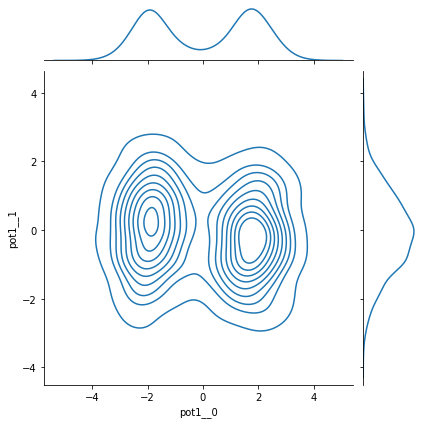

In [33]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind="kde")

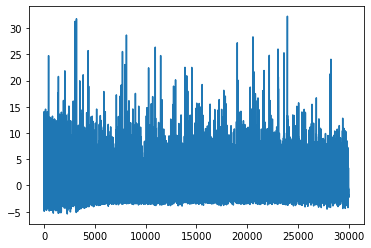

In [34]:
plt.plot(inference.hist);

In [35]:
# fmt: off
trackername = ['u_0', 'w_0', 'b_0', 'u_1', 'w_1', 'b_1',
               'grad_u_0', 'grad_w_0', 'grad_b_0', 'grad_u_1', 'grad_w_1', 'grad_b_1']
# fmt: on


def plot_tracker_results(tracker):
    fig, ax = plt.subplots(len(tracker.hist) // 2, 2, figsize=(16, len(tracker.hist) // 2 * 2.3))
    ax = ax.flatten()
    # names = list(tracker.hist.keys())
    names = trackername
    gnames = names[len(names) // 2 :]
    names = names[: len(names) // 2]
    pairnames = zip(names, gnames)

    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i * 2]
        right = ax[i * 2 + 1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title("Gradient of %s" % name)
        left.set_title("Param trace of %s" % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, "-")
            right.plot(g, "o", alpha=1 / s / 10)
        left.legend([name + "_%d" % j for j in range(len(names))])
        right.legend([gname + "_%d" % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()

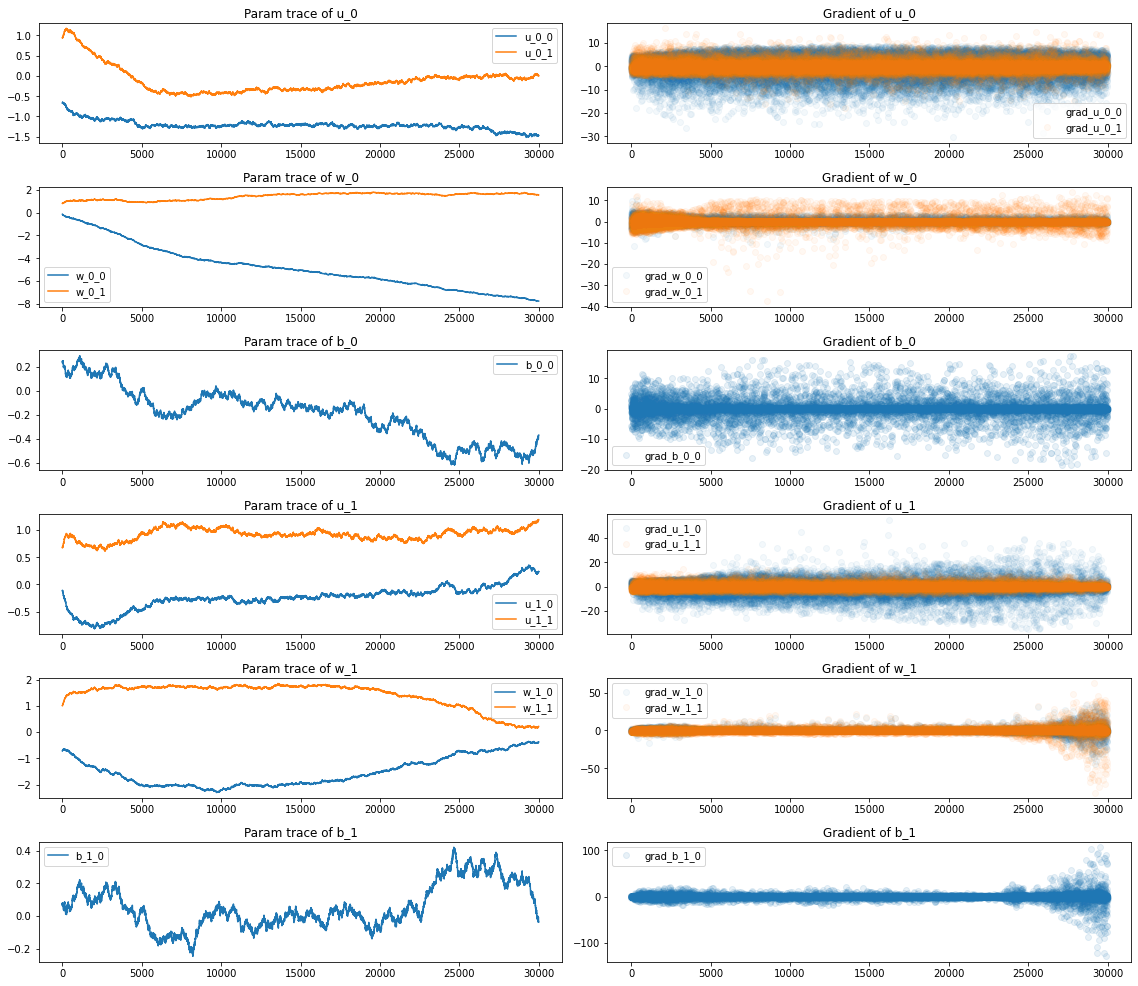

In [36]:
plot_tracker_results(tracker);